# Decomposition of data as MPS

In [1]:
import numpy as np
import math
import numpy.linalg
from itertools import product

In [2]:
def MPS(d,L,c,k,epsilon):
    '''
    input : - k=integer>2, number of singular values to keep at each SVD
            - number epsilon = other truncation parameter
            - integer L>2 = number of sites
            - integer d >1 = local dimension
            - array c = raw data vector
    output :- Asigma = list of np.array, with the matrices of the MPS decomposition at each site
            - bond_d = np array, bond dimensions
    '''
    #in case of wrong inputs: warnings
    if L < 2:
        print('The code does not work for L<2')
    
    if k < 2:
        print("cannot truncate for k<2")
    
    #reshape it into a matrix of size d.d^{L-1}
    Psi = c.reshape(d,d**(L-1)) 

    #create the outputs 
    Asigma = [] #list that will contain at each site, the matrices of the MPS
    bond_d = np.array([],dtype = int) #bond_d[i]= bond dimension between i and i+1= number of columns of the matrix at site i
    
    #do the svd on reshaped data Psi
    U, S, Vh = np.linalg.svd(Psi, full_matrices=False)
    S = np.diag(S)
    
    #add matrices and bond dimension to outputs
    Asigma.append( np.array([U[i] for i in range(0,U.shape[0])]) ) #Asigma[l][i] = ith matrix of site l= ith row of U
    bond_d = np.append(bond_d,Asigma[0].shape[1])
    #print("first S:")
    #print(S)
    #print('')
    
    #loop over the central tensors, L-2 tensors

    for i in range(1,L-1):
        
        #reshape previous S.Vh into a matrix of size (r_i.d, d^(L-1-i))
        Psi = np.dot(S, Vh)
        Psi = Psi.reshape(S.shape[0]*d, d**(L-1-i), order='F')

        #do SVD on this new Psi
        U, S, Vh = np.linalg.svd(Psi, full_matrices=False)
        
        #print("S:")
        #print(S)
        #print('with rank :')
    
        
        #compute the epsilon_rank
        rank = np.max(np.where (S > epsilon))
        
        #print(rank)

        #convert S to matrix
        S = np.diag(S)
        
        #if truncation bigger than rank, we don't troncate more than just rank truncation
        if k <= rank:
            rank = k-1
        
        # Truncate the matrices 
        U = U[:, :rank+1]
        S = S[:rank+1,:rank+1]
        Vh = Vh[:rank+1, :]

        #print("S after truncation :")
        #print(S)
        #add bond dimension of truncated matrices
        bond_d = np.append(bond_d, S.shape[0])
        #print("we add to bond dimension : ")
        #print(S.shape[0])
        #print("")
        #slice the matrix U into d matrices of size (ri,r_{i+1})
        U=np.split(U,d)

        #add the new set of matrices to Asigma
        Asigma.append(U)
        
    Psi = np.dot(S,Vh)
    Asigma.append( np.hsplit(np.dot(S,Vh),d) )
    #bond_d = np.append(bond_d, Psi.shape[0])
    
    return Asigma, bond_d



# Bijection between matrix physical indices and position in the raw data vector

We want, given a set of physical indicies $\sigma_1\sigma_2\cdots \sigma_L$, to find the position of the
corresponding coefficient in the raw data vector.

First, lets find the bijection between the set of physical indicies and the position in the first reshaped matrix $\Psi_{\sigma_1,\sigma_2\cdots \sigma_L}$. Once we have this, we can easily go back to the position in the raw data vector, since we now how python made the reshaping between the two.
Let 

$$c_{\sigma_1,...,\sigma_L}=A^{\sigma_1}\cdots A^{\sigma_L}=\sum_{a_1,a_2,...,a_L}A_{1,a_1}^{\sigma_1}A_{a_1,a_2}^{\sigma_2}\cdots A_{a_{L-1},a_{L}}^{\sigma_{L-1}}A_{\sigma_L,1}^{\sigma_L}$$


Let $\Psi_{\sigma_1,\sigma_2\cdots \sigma_L}$ be the matrix obtained after the first reshaping of the raw data vector. It has dimension $d\times d^{L-1}$. The index $\sigma_1$ determines the row position. 

To now what column index corresponds to $\sigma_2,...,\sigma_L$, we do the following : 

- $\sigma_L$ partitions the columns into set of $d^{L-2}$ columns. Its value determines if you are in the first $d^{L-2}$, in the second, or in the third, etc.
- Suppose you are in of the previous given set of columns (for example the first $d^{L-2}$ columns). The $\sigma_{L-1}$ partition this set of columns into sets of $d^{L-3}$ columns. Its value determines again in which set we are.
- Repeat this procedure, until we go to $\sigma_1$, which determines the position in the previous obtained set.


If each physical index lives in $\{1,...,d\}$, then the column position corresponding to $\sigma_2,...,\sigma_L$ is 

$$d^{L-2}(\sigma_L-1)+d^{L-3}(\sigma_{L-1}-1)+\cdots + d(\sigma_3-1)+\sigma_2$$

In python however, each physical index starts from 0, to $d-1$, so it is

$$d^{L-2}\sigma_L+d^{L-3}\sigma_{L-1}+\cdots + d\sigma_3+(\sigma_2+1)-1=\sum_{i=0}^{L-2}d^i\sigma_{i+2}$$

So finally, the bijective map called $f_1$ between $\sigma_1,\sigma_2\cdots \sigma_L$ and the position in the matrix $(i,j)$ is : 

$$i=\sigma_2,\qquad j=\sum_{i=0}^{L-2}d^i\sigma_{i+2}$$


In [3]:
#given a set of L physical indicies, returns the position in matrix obtained by the first reshaping of the raw data

def f1(sigmas,L):
    """ input : np array [\sigma_1,...,\sigma_L], L = size of sigmas
        output : np array [i,j] with i raw index and j column index
    """
    
    matrix_indices = np.array([0,0])
    matrix_indices[0] = sigmas[0]
    
    for i in range(0,L-1):
        matrix_indices[1] += (d**i)*sigmas[i+1]
    
    return matrix_indices

Now that we have the position $(i,j)$ in the first $\Psi$ matrix, we want to have the position in the raw data vector. In other words, we are looking for the bijective map $f_2$ 

$$I=:f_2(i,j)=f_2(f_1(\sigma_1,...,\sigma_L))$$

where $I$ is the index in the raw data vector. In general, for a matrix $A$ of size $m\times n$ that has been reshaped from a vector of size $m\cdots n$ with row-major ordering, one has for a given position $(i,j)$ in $A$, the following bijection 

$$I=im+j$$

if we assume that indices start from $0$. In our case, since $A=\Psi$ is of size $d\times d^{L-1}$, we have

$$I=id^{L-1}+j$$



In [4]:
def f2(matrix_indices, nb_columns, nb_rows):
    '''
    input: - matrix_indices = np.array, row/column indices in a matrix A 
           - nb_columns = int, number of columns of A
           - nb_rows = int,number of rows of A
    output: - the position I in the raw data vector obtained from row_ordering reshaping A
            - error if nb_columns and nb_rows are not compatible with matrix_indices
    '''
    
    if matrix_indices[0]<0 or matrix_indices[0]>nb_rows:
        raise IndexError('Matrix indices cannot be accessed')
    
    if matrix_indices[1]<0 or matrix_indices[1]>nb_columns:
        raise IndexError('Matrix indices cannot be accessed')
    
    return matrix_indices[0]*nb_columns+matrix_indices[1]


In [5]:
#test of MPS function

#rank of the initial tensor
L = 4

#dimension of each leg
d = 2

#truncation parameters
epsilon = 0.01
k=100*100

#the raw data vector
c = np.random.uniform(0, 1, size=(1, d**L))

#MPS(d,L,c,k,epsilon)

([array([[ 0.82187304, -0.5696707 ],
         [ 0.5696707 ,  0.82187304]]),
  [array([[-0.54000757,  0.69586427,  0.34444159,  0.32484569],
          [ 0.11393652, -0.35033245,  0.0096607 ,  0.92961944]]),
   array([[-0.81745245, -0.56380883, -0.03700347, -0.11190102],
          [-0.16486897,  0.27415269, -0.93802847,  0.13327087]])],
  [array([[-7.91432327e-01,  9.34428960e-02],
          [-1.12663603e-01, -2.38351978e-01],
          [-1.42279564e-01,  1.84923533e-01],
          [-6.29617353e-04, -1.72809419e-02]]),
   array([[-5.11927650e-01, -2.69285940e-03],
          [ 1.66629804e-01,  8.87113706e-01],
          [ 2.25526648e-01, -3.36081180e-01],
          [ 4.83974918e-04, -5.73384086e-03]])],
  [array([[1.30141335],
          [0.53909256]]),
   array([[ 1.36205876],
          [-0.51508956]])]],
 array([2, 4, 2]))

In [6]:
def approximate_data(d,L,c,k,epsilon):

    Asigma = MPS(d,L,c,k,epsilon)[0]
    c_tilde = np.zeros(d**L)
    
    #print("number of sites L= "+str(L))
    #print("local dimension d= "+str(d))
    #print("raw data = "+str(c))
    #print("")
    #print("")

    #generate a set containing all the posible values of physical indicies = {sigma_1,...,sigma_L}
    i = [j for j in range(d)]
    cartesian_product = (list(product(i, repeat=L)))

    #go over all the physical indicies and compute the product of matrices, print the result
    for i in cartesian_product:

        #print("physical indices: "+str(i))

        #evaluate the product of matrices with these physical indicies

        prod = Asigma[0][i[0]]
        for j in range( 1,len(i) ):

            prod = np.dot( prod, Asigma[j][i[j]] )
            c_tilde[f2( f1(i,L), d**(L-1), d )] = prod[0]
            
        #print("product of matrices = "+str(prod))    
        #print( "position in the raw data vector = "+str( f2( f1(i,L), d**(L-1), d ) ) )    
        #print("")
    
    return c_tilde   

# Truncation of the singular values

Now, we write a cell that will do the following : 
- fix $\epsilon$
- compute the maximum bond dimension $D$ for $k = +\infty$
- then for $k=D+10$ to $k=d$, compute :

$$e_{c}(k,\epsilon):=\frac{ |c-\tilde{c}(k,\epsilon) |}{ | \psi|}$$

where $c$ is the original raw data vector and $\tilde{c}(k,\epsilon)$ the raw data obtained from a MPS decomposition with a truncation of the $k,\epsilon$ singular values.


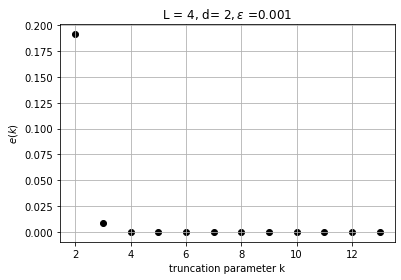

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
import time
start_time = time.time()

#compute the relative error induced by truncation

k = 10**1000 

d = 2

L = 4

epsilon = 0.001

errors = np.array([])

c = np.random.uniform(0, 1, size=(1, d**L))

norm_c = np.linalg.norm(c)

c = c/norm_c

D = max(MPS(d,L,c,k,epsilon)[1])+10

for j in range(d,D):
    #print(j)
    #errors = np.append(errors, math.log( ( np.linalg.norm(c-approximate_data(j)) ) / (norm_c) ) )
    errors = np.append(errors,((np.linalg.norm(c-approximate_data(d,L,c,j,epsilon)))))
    
# Create your NumPy arrays (replace these with your actual data)
x_values = [i for i in range(d,D)]
y_values = errors

# Create a scatter plot
plt.scatter(x_values, y_values, marker='o', color='black', label='Data Points')

# Add labels and a title
plt.xlabel('truncation parameter k')
plt.ylabel('$e(k)$')
plt.title('L = '+str(L)+', d= '+str(d)+'$, \epsilon$ ='+str(epsilon))

# Add a grid
plt.grid(True)

# Save the figure
filename='truncation_error_d='+str(d)+'L='+str(L)+'eps='+str(epsilon)+'.pdf'
#plt.savefig('truncation_error_plot/'+filename)

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")


Now we write a cell that fix the value of $k=\infty$ and that compute the error for several values of $\epsilon$.

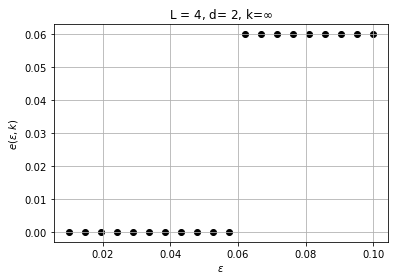

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

#compute the relative error induced by truncation

k = 1000**1000 

d = 2

L = 4

errors = np.array([])

c = np.random.uniform(0, 1, size=(1, d**L))

norm_c = np.linalg.norm(c)

c = c/norm_c

eps = np.linspace(0.01, 0.1, 20)

for epsilon in eps:
    #errors = np.append(errors, math.log( ( np.linalg.norm(c-approximate_data(j)) ) / (norm_c) ) )
    errors = np.append(errors, ( ( np.linalg.norm(c-approximate_data(d,L,c,k,epsilon)) ) / 1 ) )
    
# Create your NumPy arrays (replace these with your actual data)
x_values = [i for i in eps]
y_values = errors

# Create a scatter plot
plt.scatter(x_values, y_values, marker='o', color='black', label='Data Points')

# Add labels and a title
plt.xlabel('$\epsilon$')
plt.ylabel('$e(\epsilon,k)$')
plt.title('L = '+str(L)+', d= '+str(d)+', k=$\infty$')

# Add a grid
plt.grid(True)

# Save the figure
filename='truncation_error_d='+str(d)+'L='+str(L)+'k=1000**2'+'.pdf'
#plt.savefig('truncation_error_plot/fix_k'+filename)




# Reading an image and compressing with "brut force"


We can read an tiff image in python, and also convert this image into an array. We can also convert an array into an
image.

In [21]:
from PIL import Image

#open the image
#im = Image.open('images/ruler.512.tiff')
#im.show()

#convert the image in a np array
#imarray = np.array(im)
#print(imarray.shape)

#create a new array
#array = np.full((1024, 1024), 100,dtype='uint8')

#convert this array into an image
#p=Image.fromarray(array)
#p.show()

In [10]:
def image_to_vector(image_name,d,R):
    '''- input : - image_name=string. name of image located in the 'images' foler of the workspace, tiff format, grayscale
                 - d**R = number of pixel we take "vertically"
       - output : numpy array, obtained first by converting the image to a np array of size (d**(R),d**(R)) and 
                  then reshaping the array into a 1D array of size d**L
    '''
    
    #open image and convert to array
    IM = Image.open('images/'+image_name)
    #IM.show()
    
    IMarray = np.array(IM)
    #print(IMarray.shape)
        
    #check d**L<number of pixels in image 
    if d**(2*R) <= IMarray.shape[0]*IMarray.shape[1]:
        
        #slice the array to match a d**L raw data vector size
        IMarray = IMarray[:d**R, :d**R]
        IM = Image.fromarray(IMarray)

        #reshape the array into 1D array
        IMarray = IMarray.reshape(d**(2*R))

        return IMarray,IM
        
    else:
        print("Number of pixels > d**(2*R)")
            
        return None,None

In [11]:
#image_to_vector('5.1.12.tiff',2,6)[1].show()

In [12]:
def vector_to_image(array):
    size = array.shape[0]
    half_size = int(math.sqrt(size))
    r_array = array.reshape(half_size,half_size)
    IM = Image.fromarray(r_array)
    return r_array, IM

In [13]:
#vector_to_image( image_to_vector('5.3.01.tiff',2,10)[0] )[1].show()


In [14]:
#d = 2
#R = 4
#image_name = '5.3.01.tiff'
#k = 1000000
#epsilon = 0.01
#data = image_to_vector(image_name,d,R)[0]
#norm =np.linalg.norm(image_to_vector(image_name,d,R)[0])
#data = data/norm
#compressed_image = approximate_data( d, 2*R, data , k,epsilon )
#vector_to_image(compressed_image*norm)[1].show()

# Compressing more efficiently

For an arbitrary tensor $f(\sigma_1,...,\sigma_L)$, as it was demonstrated numerically, the bond dimensions follow 
the same curve as the maximum bond dimension. This means that truncating the number of singular values at each step
is a loss of information. However, $f$ is such that two consecutive physical indicies are highly entanglent, and no entangled if there are far appart, then (and I don't understand why for the moment), the bond dimension will stay under a plateau, allowing us to compress more. 

Lets define $n=2^R$. Consider an image of $n\times n$ pixel. Numerically, such an image is encoded as a matrix of size 
$n \times n$, where each entry is the value of the pixel, say in grayscale. Consider a pixel/entry of the matrix $(i,j)$. Then for any $i,j\in \{0,...,n-1\}$, then $\frac{i}{n}\in [0,1[$ and $\frac{j}{n}\in [0,1[$ and so they have a bit representation : 

$$\frac{i}{N}=\frac{x_1}{2}+\frac{x_2}{2^2}+\frac{x_3}{2^3}+\cdots +\frac{x_R}{2^R} \quad(1)$$

$$\frac{j}{N}=\frac{y_1}{2}+\frac{y_2}{2^2}+\frac{y_3}{2^3}+\cdots +\frac{y_R}{2^R} \quad (2)$$

Where $x_i,y_i\in \{0,1\}$. We can thus write $$i=N(x_1,...,x_R),\qquad j=N(y_1,...,y_R)$$

Let $$f(x_1,y_1,x_2,y_2,...,x_R,y_R)$$ be the color of the pixel. This is a rank $2R$ tensor with physical indicies

$$\sigma_1,\sigma_2=x_1,y_1,\cdots,\quad \sigma_{2R-1},\sigma_{2R}=x_R,y_R$$

So we have encoded this image in a tensor with physical indicies. To apply our MPS decomposition, we need to code something that takes the image as input, and returns the raw data vector $c$ representing $f(x_1,y_1,...)$. To do that :

- $$f_2(f_1(x_1,y_1,...))=\text{ position in raw data vector}$$

- $$x_1,y_1,... \leftrightarrow (i,j) \leftrightarrow \text{ Pixel value}$$

Open questions : is there a way to just reshape the matrix image in a vector, such that the above construciton is done ?

To construct the raw data vector, we :
- give an image and a $R$ as inputs.
- go over all the possible $\{\sigma_1,...,\sigma_{2R}\}$
- compute the pixel position in the image array using (1) and (2)
- compute the pixel value corresponding at this position in the array image
- find position $I$ in data vector using $I=f_2\circ f_1(\sigma_1,\sigma_2,...)$
- add the pixel value to the raw data vector at position $I$

We do this in the function $\texttt{image_to_vector_bits()}$. Before, we define a function $\texttt{bits_to_int}(bits)$
that takes a bit sequence in argument, and returns the corresponding real number $x$ in [0,1], in base $10$.


In [15]:
def bits_to_base10(bits):
    '''
    intput : - bits = list, of integers 0 or 1
    output : - x = corresponding number in base 10
    '''
    x = 0
    for j in range(0,len(bits)):
        x += bits[j]/(2**(j+1))
    return x

In [16]:
def image_to_vector_bits(image_name, R, already_array):
    '''
    input : - image_name = name of a square image
            - already_array = if true, then the image_name is a already an np.array of dim 2
            - R = int, where 2^R\times 2^R is the total number of pixel we put in the raw data vector
    output : - c = 1D np.array 
    '''
    #create output
    c = np.full(2**(2*R), 0)
    
    if already_array == False:
    
        #open image and convert to array
        IM = Image.open('images/'+image_name)

        #convert into an array
        IMarray = np.array(IM)
        
    elif already_array == True:
        
        IMarray = image_name
    
    #check d**L<number of pixels in image 
    if 2**(2*R) <= IMarray.shape[0]*IMarray.shape[1]:
    
        #generate a set containing all the posible values of physical indicies = {sigma_1,...,sigma_{2R}}
        i = [j for j in range(2)]
        cartesian_product = list(product(i, repeat=2*R))

        #go over all the physical indicies
        for i in cartesian_product:
            #print("i is :")
            #print(i)

            #extract the physical indicies s1=x1,s3=x2,...
            x = i[::2]
            #print("xs")
            #print(x)
            I = int( (2**R) * bits_to_base10(x) )

            #extract the physical indicies s2=y1,s4=y2,...
            y = i[1::2]
            #print('ys')
            #print(y)
            J = int ( (2**R) * bits_to_base10(y) )

            #print("position in image array is :")
            #print(I,J)
            #print("")

            #compute pixel value
            pixel = int(IMarray[I,J])

            #put the value in c
            c[f2( f1(i,2*R), 2**(2*R-1), 2 )] = pixel

        return c
    
    else:
        print("Number of pixels > 2**(2*R)")
            
        return None,None

Now that we have a function that encode an image as a raw data vector, using the bit construction, we can use it on 
a image.

In [17]:
#image name to be converted, 2^R x 2^R pixel will be taken
#image_name = '1.4.04.tiff'
#R = 2

#convert to raw data vector using the bit way
#raw_data = image_to_vector_bits(image_name, R, False)
#raw_data = raw_data/np.linalg.norm(raw_data)

#using the "normal" way
#raw_data2 = image_to_vector(image_name, 2, R)[0]
#raw_data2 = raw_data2/np.linalg.norm(raw_data2)

Lets also create a half black, half white image to test this bit construction.

In [18]:
#create a half black, hald white image for test
R = 4
image_size = 2**R

# Create a black and white checkerboard pattern
bandw = np.zeros((image_size, image_size), dtype=np.uint8)

# Fill half of the image with white
bandw[:, :image_size // 2] = 255

# Print the resulting image
#print(bandw)

#convert to raw data vector using the bit way
raw_data_bandw = image_to_vector_bits(bandw, R, True)
raw_data_bandw = raw_data_bandw/np.linalg.norm(raw_data_bandw)
for i in raw_data_bandw:
    #print(i)
#print("")

#using the "normal" way
raw_data_bandw2 = bandw.reshape(2**(2*R))
raw_data_bandw2 = raw_data_bandw2/np.linalg.norm(raw_data_bandw2)
for i in raw_data_bandw2:
    #print(i)


[[255 255 255 255 255 255 255 255   0   0   0   0   0   0   0   0]
 [255 255 255 255 255 255 255 255   0   0   0   0   0   0   0   0]
 [255 255 255 255 255 255 255 255   0   0   0   0   0   0   0   0]
 [255 255 255 255 255 255 255 255   0   0   0   0   0   0   0   0]
 [255 255 255 255 255 255 255 255   0   0   0   0   0   0   0   0]
 [255 255 255 255 255 255 255 255   0   0   0   0   0   0   0   0]
 [255 255 255 255 255 255 255 255   0   0   0   0   0   0   0   0]
 [255 255 255 255 255 255 255 255   0   0   0   0   0   0   0   0]
 [255 255 255 255 255 255 255 255   0   0   0   0   0   0   0   0]
 [255 255 255 255 255 255 255 255   0   0   0   0   0   0   0   0]
 [255 255 255 255 255 255 255 255   0   0   0   0   0   0   0   0]
 [255 255 255 255 255 255 255 255   0   0   0   0   0   0   0   0]
 [255 255 255 255 255 255 255 255   0   0   0   0   0   0   0   0]
 [255 255 255 255 255 255 255 255   0   0   0   0   0   0   0   0]
 [255 255 255 255 255 255 255 255   0   0   0   0   0   0   0 

and finally lets use it on the snap shot we designed for the kagome lattice

In [19]:
import sys
sys.path.append("/Users/gabinleroy/Desktop/MCMC_Python")
from transfertmatrixkagome import fc
from transfertmatrixkagome import real_space
R = 7
N = 3 # N +1 = number of 2 units 
Nc = 3 #Nc+1 = number of col
a = 0.1

ys = []
for i in range(2,4):
    array_snapshot = real_space(i,i,fc,a)
    for snapshot in array_snapshot:
        snapshot = image_to_vector_bits(snapshot, R, True)
        snapshot = snapshot/np.linalg.norm(snapshot)
        ys.append(MPS(2, 2*R,snapshot, k ,epsilon)[1])
#raw_data_snap = image_to_vector_bits(array_snapshot, R, True)
#raw_data_snap = raw_data_snap/np.linalg.norm(raw_data_snap)

#randomq = np.random.choice([0, 1, 2, 3, 4], size=(N+1, N+1))
#raw_data_snaprandom = image_to_vector_bits(randomq, R, True)
#raw_data_snaprandom = raw_data_snaprandom/np.linalg.norm(raw_data_snap)

TypeError: real_space() missing 1 required positional argument: 'desired'

Read the snapshot data from the textfile : contains many np.array where each np.array is a snapshot. The size of a snap shot is (200,200) when figsize = (1,1). 

In [ ]:
A = np.loadtxt('output.txt',delimiter=',')
print(A.shape)
def slice_matrix(original_matrix, num_slices):
    N1, N2 = original_matrix.shape
    slice_size = N1 // num_slices

    # Check if the original matrix can be evenly divided into the desired number of slices
    if N1 % num_slices != 0:
        raise ValueError("The matrix size is not divisible by the number of slices")

    # Slice the original matrix into p matrices and store them in a list
    sliced_matrices = [original_matrix[i * slice_size:(i + 1) * slice_size, :] for i in range(num_slices)]

    return sliced_matrices

#list of all the snapshots
A = slice_matrix(A,10)

# Bond dimensions

In [ ]:
import numpy as np
import numpy.linalg
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

#rank of the initial tensor
L = 2*R

#dimension of each leg
d = 2

#truncation parameters
epsilon = 0.001
k=200

# Create your NumPy arrays (replace these with your actual data)
x_values = [i for i in range(0,L-1)] #L-1 bond dimensions 

#y1_values = MPS(d, L, raw_data, k,epsilon)[1]
#y2_values = MPS(d, L, raw_data2, k,epsilon)[1]
#y3_values = MPS(d, L, raw_data_bandw, k ,epsilon)[1]
#y4_values = MPS(d, L, raw_data_bandw2, k , epsilon)[1]
compt = 1
for y_values in ys:
    print(y_values)
    if compt <= 12:
        plt.scatter(x_values, y_values, marker = 'o', color='b', label = 'N=Nc=2' if compt == 1 else "")
    else:
         plt.scatter(x_values, y_values, marker = 'x', color='r', label = 'N=Nc=3'if compt == 13 else "" )
    compt += 1
#y6_values = MPS(d, L, raw_data_snaprandom, k ,epsilon)[1]

# Create a scatter plot for the y's array
#plt.scatter(x_values, y1_values, marker='o', color='blue', label = 'bits way')
#plt.scatter(x_values, y2_values, marker='x', color='red', label =' first way')
#plt.scatter(x_values, y3_values, marker='o', color='blue', label =' bits way')
#plt.scatter(x_values, y4_values, marker='x', color='red', label =' first way')
#plt.scatter(x_values, y6_values, marker='o', color='blue', label ='random')

# Add labels and a title
plt.xlabel('site')
plt.ylabel('Bond dimension')
plt.title('d='+str(d)+', L='+str(L)+', k='+str(k)+'$, \epsilon$='+str(epsilon))

# Add a grid
plt.grid(True)

# Add a horizontal line at d^(L/2)
#plt.axhline(y=d**(L/2), color='red', linestyle='--', label='$d^{L/2}$')

#add legend
plt.legend()

# Save the figure
filename = 'd='+str(d)+'L='+str(L)+'k='+str(k)+'eps='+str(epsilon)+'.pdf'
plt.savefig('bond_dim_KSI_vs_Krandom/'+filename,format='pdf')

# Display the plot (if you're using a Jupyter notebook, you can omit this line)
plt.show()

